In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
plt.rcParams["figure.figsize"] = (20,10)

In [4]:
df_application_train = pd.read_csv('application_train.csv')
df_application_train['SK_ID_CURR'] = df_application_train['SK_ID_CURR'].astype(str)

df_application_train = df_application_train[['SK_ID_CURR','TARGET']]
df_application_train.set_index('SK_ID_CURR')
df_credit_card_balance = pd.read_csv('credit_card_balance.csv')
df_credit_card_balance.set_index('SK_ID_CURR')


,SK_ID_PREV,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
378907,2562384,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.00,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
363914,2582071,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.00,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
371185,1740877,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.00,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
337855,1389973,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.00,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
126868,1891521,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.00,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328243,1036507,-9,0.000,45000,NaN,0.0,NaN,NaN,0.000,NaN,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
347207,1714892,-9,0.000,45000,0.0,0.0,0.0,0.0,0.000,1879.11,...,0.000,0.000,0.0,0,0.0,0.0,23.0,Active,0,0
215757,1302323,-9,275784.975,585000,270000.0,270000.0,0.0,0.0,2250.000,375750.00,...,273093.975,273093.975,2.0,2,0.0,0.0,18.0,Active,0,0


In [3]:
def get_clean_credit_new(df_credit_raw):
    useful = ['MONTHS_BALANCE', 'AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_TOTAL_RECEIVABLE','NAME_CONTRACT_STATUS_Completed','SK_ID_CURR','SK_DPD','SK_DPD_DEF']
        

        
    full_dummies = pd.get_dummies(df_credit_raw,columns = ['NAME_CONTRACT_STATUS'])
    full_trimmed = full_dummies[useful]
    dpd_counts_sum = full_trimmed.groupby(['SK_ID_CURR'])['SK_DPD'].sum().reset_index()
    dpd_df_counts_sum = full_trimmed.groupby(['SK_ID_CURR'])['SK_DPD_DEF'].sum().reset_index()
    full_trimmed['SK_DPD_SUM'] = dpd_counts_sum['SK_DPD']
    full_trimmed['SK_DPD_DEF_SUM'] = dpd_df_counts_sum['SK_DPD_DEF']
    
    full_not_nan = full_trimmed.fillna(value=0)
    
    return full_not_nan.drop(columns=['SK_DPD','SK_DPD_DEF'])

In [5]:
def get_clean_credit(df_credit_raw,df_application_raw):
    useful = ['MONTHS_BALANCE', 'AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_TOTAL_RECEIVABLE','SK_ID_CURR','TARGET','SK_DPD','SK_DPD_DEF']
        
    df_application_raw['SK_ID_CURR'] = df_application_raw['SK_ID_CURR'].astype(str)

    df_application_raw = df_application_raw[['SK_ID_CURR','TARGET']]
    df_application_raw.set_index('SK_ID_CURR')
    
    df_credit_raw['SK_ID_CURR'] = df_credit_raw['SK_ID_CURR'].astype(str)
    
    full = pd.merge(
    df_credit_raw,
    df_application_raw, #here the differance
    on='SK_ID_CURR',
    how='left' #and add the how='left'
    )
    full.set_index('SK_ID_CURR')
        
    full_dummies = pd.get_dummies(full,columns = ['NAME_CONTRACT_STATUS'])
    full_trimmed = full_dummies[useful]
    dpd_counts_sum = full_trimmed.groupby(['SK_ID_CURR'])['SK_DPD'].sum()
    dpd_df_counts_sum = full_trimmed.groupby(['SK_ID_CURR'])['SK_DPD_DEF'].sum()
    full_trimmed['SK_DPD_SUM'] = dpd_counts_sum
    full_trimmed['SK_DPD_DEF_SUM'] = dpd_df_counts_sum
    
    full_not_nan = full_trimmed.dropna(subset=['TARGET'], how='all')
    full_not_nan = full_not_nan.fillna(value=0)
    
    return full_not_nan.drop(columns=['SK_DPD','SK_DPD_DEF'])

In [18]:
df_clean = get_clean_credit(df_credit_card_balance,df_application_train)

<ipython-input-5-6cd1131f8233>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_trimmed['SK_DPD_SUM'] = dpd_counts_sum
<ipython-input-5-6cd1131f8233>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_trimmed['SK_DPD_DEF_SUM'] = dpd_df_counts_sum


<AxesSubplot:title={'center':'AMT_BALANCE'}, xlabel='TARGET'>

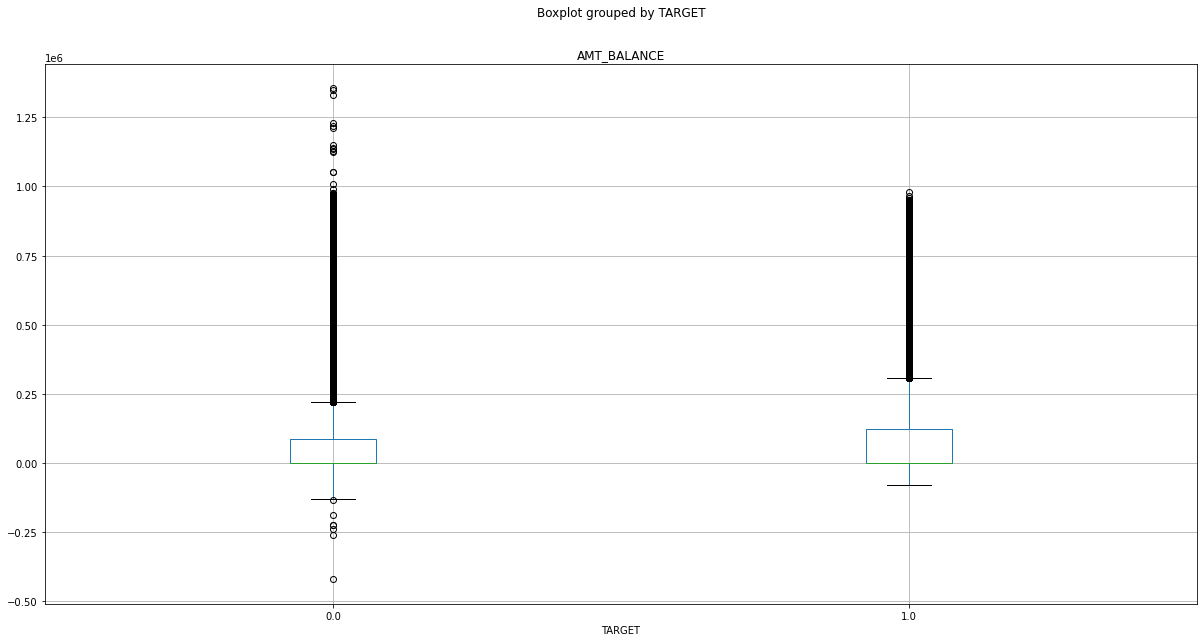

In [47]:
df_clean.boxplot(by ='TARGET', column =['AMT_BALANCE'], grid = True)

<AxesSubplot:title={'center':'AMT_CREDIT_LIMIT_ACTUAL'}, xlabel='TARGET'>

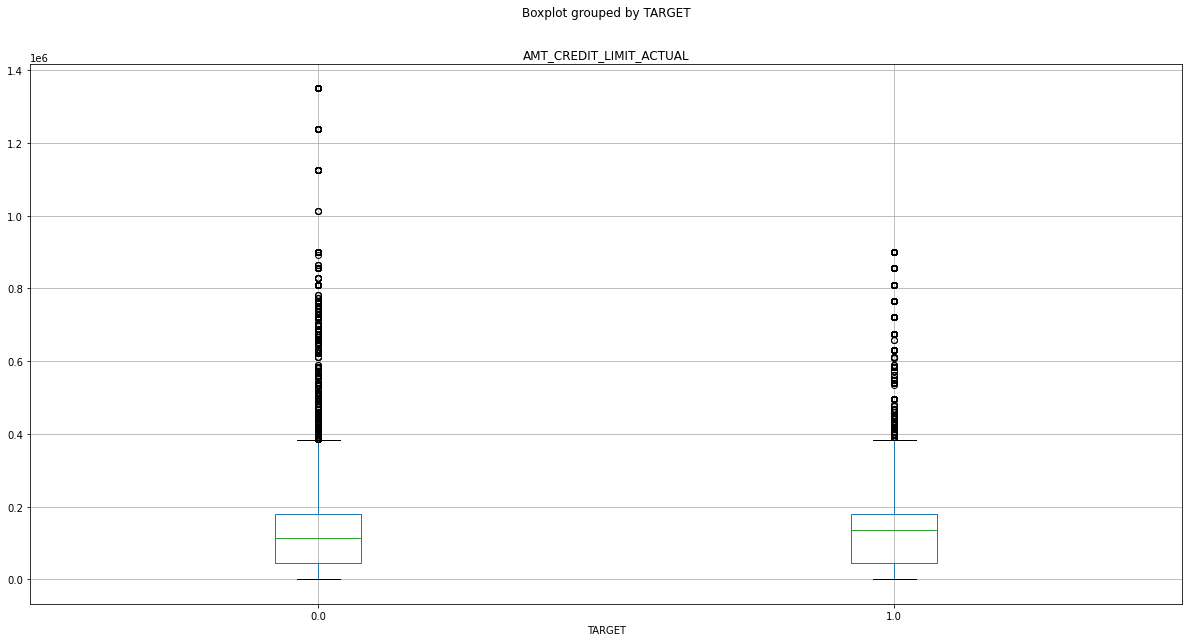

In [48]:
# ffg,ax = plt.subplots(figsize=(20,10))
df_clean.boxplot(by ='TARGET', column =['AMT_CREDIT_LIMIT_ACTUAL'], grid = True)

<AxesSubplot:title={'center':'MONTHS_BALANCE'}, xlabel='TARGET'>

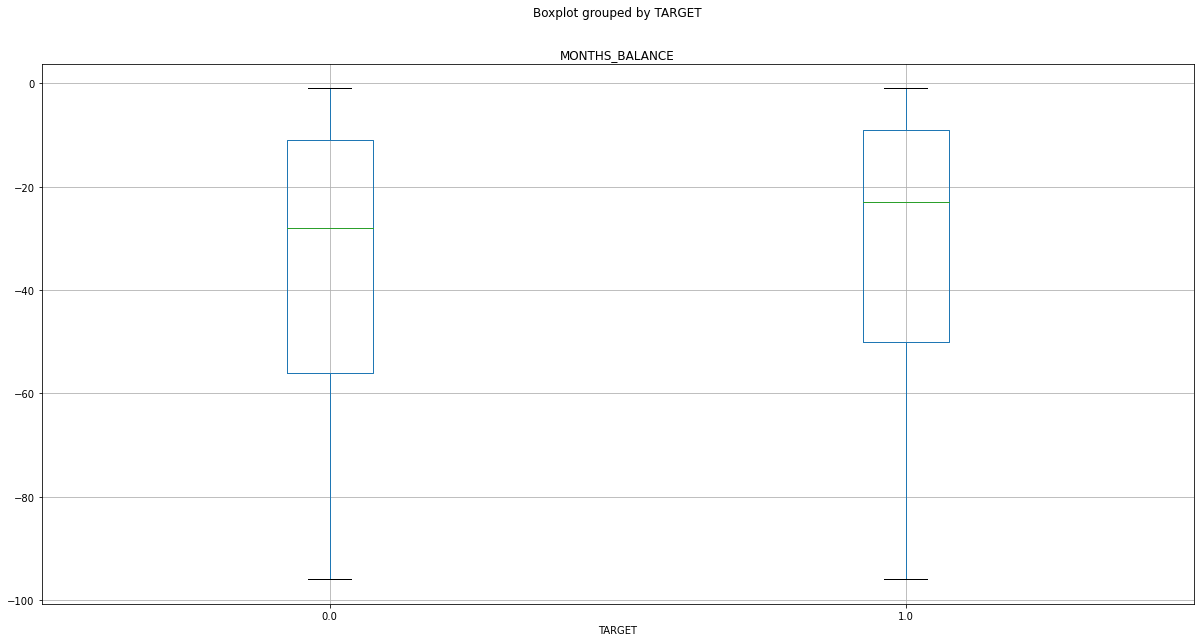

In [50]:
df_clean.boxplot(by ='TARGET', column =['MONTHS_BALANCE'], grid = True)